# Name: Omkar Thorve
# PRN: 24070149016

# GAN architecture

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Hyperparameters
batch_size = 64
lr = 0.0002
beta1 = 0.5
epochs = 20
latent_dim = 100
image_channels = 1  # Grayscale for MNIST
image_size = 28

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is latent vector z
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, image_size * image_size * image_channels),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        img = self.main(z)
        img = img.view(img.size(0), image_channels, image_size, image_size)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is 28x28x1
            nn.Flatten(),

            nn.Linear(image_size * image_size * image_channels, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, img):
        validity = self.main(img)
        return validity

# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training function
def train_gan():
    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # Labels for real and fake images
            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Train with real images
            real_output = discriminator(real_imgs)
            d_loss_real = criterion(real_output, real_label)

            # Train with fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(fake_output, fake_label)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()

            # Generate new fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs)

            # Generator loss - aims to maximize log(D(G(z)))
            g_loss = criterion(fake_output, real_label)
            g_loss.backward()
            optimizer_G.step()

            # Print progress
            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch {i+1}/{len(dataloader)} "
                      f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

        # Save generated images after each epoch
        if (epoch + 1) % 5 == 0:
            save_images(epoch)

# Function to save generated images
def save_images(epoch):
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        gen_imgs = generator(z).cpu().detach()

        # Denormalize images
        gen_imgs = gen_imgs * 0.5 + 0.5

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(gen_imgs[i, 0, :, :], cmap='gray')
            plt.axis('off')
        plt.savefig(f"mnist_gan_epoch_{epoch+1}.png")
        plt.close()

# To train the model
if __name__ == "__main__":
    train_gan()

    # Save models
    torch.save(generator.state_dict(), 'mnist_generator.pth')
    torch.save(discriminator.state_dict(), 'mnist_discriminator.pth')

    # Generate final sample images
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        gen_imgs = generator(z).cpu().detach()

        # Denormalize images
        gen_imgs = gen_imgs * 0.5 + 0.5

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(gen_imgs[i, 0, :, :], cmap='gray')
            plt.axis('off')
        plt.savefig("mnist_gan_final.png")
        plt.close()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 49.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.44MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/20] Batch 100/938 Loss D: 1.5239, Loss G: 0.6278
Epoch [1/20] Batch 200/938 Loss D: 1.2809, Loss G: 0.8468
Epoch [1/20] Batch 300/938 Loss D: 0.9477, Loss G: 1.0413
Epoch [1/20] Batch 400/938 Loss D: 0.9392, Loss G: 1.3098
Epoch [1/20] Batch 500/938 Loss D: 0.9802, Loss G: 1.0517
Epoch [1/20] Batch 600/938 Loss D: 0.6947, Loss G: 1.6694
Epoch [1/20] Batch 700/938 Loss D: 0.7396, Loss G: 1.7858
Epoch [1/20] Batch 800/938 Loss D: 0.7355, Loss G: 1.8912
Epoch [1/20] Batch 900/938 Loss D: 0.9824, Loss G: 1.5046
Epoch [2/20] Batch 100/938 Loss D: 0.9465, Loss G: 1.1622
Epoch [2/20] Batch 200/938 Loss D: 1.0566, Loss G: 2.3164
Epoch [2/20] Batch 300/938 Loss D: 0.8483, Loss G: 2.4626
Epoch [2/20] Batch 400/938 Loss D: 0.8440, Loss G: 1.5700
Epoch [2/20] Batch 500/938 Loss D: 0.9684, Loss G: 1.4098
Epoch [2/20] Batch 600/938 Loss D: 0.9219, Loss G: 2.4962
Epoch [2/20] Batch 700/938 Loss D: 0.8515, Loss G: 1.4611
Epoch [2/20] Batch 800/938 Loss D: 0.8214, Loss G: 1.7054
Epoch [2/20] B

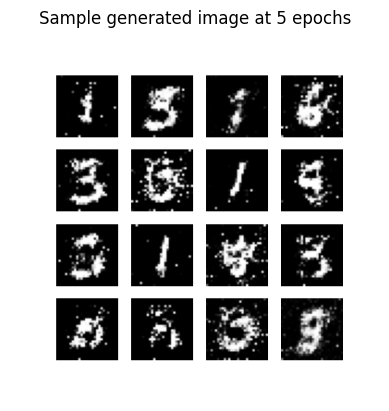

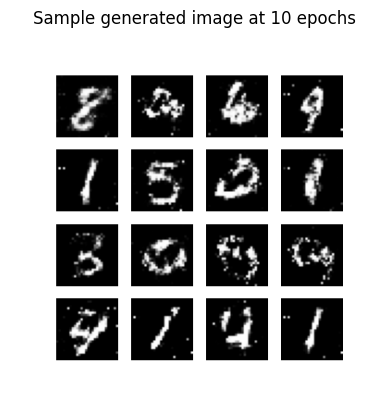

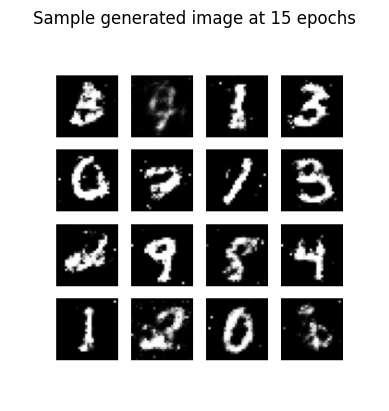

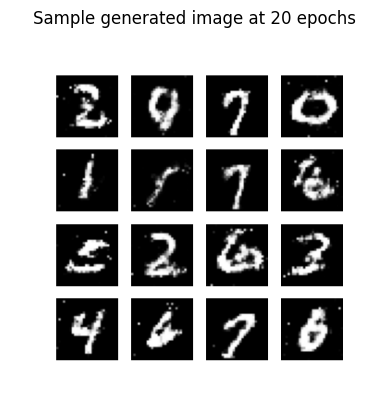

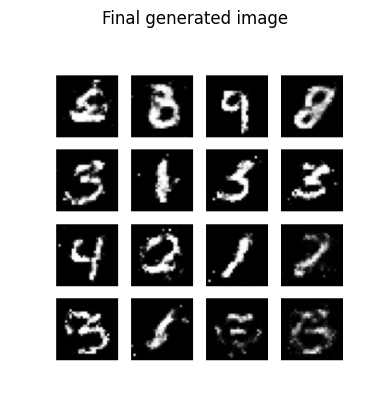

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show the image from epoch 5
img = mpimg.imread('mnist_gan_epoch_5.png')
plt.imshow(img)
plt.title('Sample generated image at 5 epochs')
plt.axis('off')
plt.show()

# Show the image from epoch 10
img = mpimg.imread('mnist_gan_epoch_10.png')
plt.imshow(img)
plt.title('Sample generated image at 10 epochs')
plt.axis('off')
plt.show()

# Show the image from epoch 15
img = mpimg.imread('mnist_gan_epoch_15.png')
plt.imshow(img)
plt.title('Sample generated image at 15 epochs')
plt.axis('off')
plt.show()

# Show the image from epoch 15
img = mpimg.imread('mnist_gan_epoch_20.png')
plt.imshow(img)
plt.title('Sample generated image at 20 epochs')
plt.axis('off')
plt.show()

# Show the final generated image
img = mpimg.imread('mnist_gan_final.png')
plt.imshow(img)
plt.title('Final generated image')
plt.axis('off')
plt.show()


# Evaluate

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from scipy import linalg


Training GAN with latent dimension: 100
Epoch [1/15] Loss D: 0.5812, Loss G: 1.0065
Epoch [2/15] Loss D: 0.2226, Loss G: 1.9235
Epoch [3/15] Loss D: 0.2830, Loss G: 2.2209
Epoch [4/15] Loss D: 0.4342, Loss G: 2.1470
Epoch [5/15] Loss D: 0.7014, Loss G: 1.5690
Epoch [6/15] Loss D: 0.9964, Loss G: 1.0739
Epoch [7/15] Loss D: 1.0522, Loss G: 0.9184
Epoch [8/15] Loss D: 1.0701, Loss G: 0.9018
Epoch [9/15] Loss D: 1.0617, Loss G: 0.9548
Epoch [10/15] Loss D: 1.0980, Loss G: 0.9539
Epoch [11/15] Loss D: 1.1394, Loss G: 0.9280
Epoch [12/15] Loss D: 1.1469, Loss G: 0.9100
Epoch [13/15] Loss D: 1.1704, Loss G: 0.9074
Epoch [14/15] Loss D: 1.1720, Loss G: 0.9243
Epoch [15/15] Loss D: 1.1892, Loss G: 0.8889

Training GAN with latent dimension: 200
Epoch [1/15] Loss D: 0.5475, Loss G: 1.0666
Epoch [2/15] Loss D: 0.2183, Loss G: 1.9987
Epoch [3/15] Loss D: 0.3008, Loss G: 2.2417
Epoch [4/15] Loss D: 0.4681, Loss G: 2.1010
Epoch [5/15] Loss D: 0.9141, Loss G: 1.2529
Epoch [6/15] Loss D: 1.0693, Los

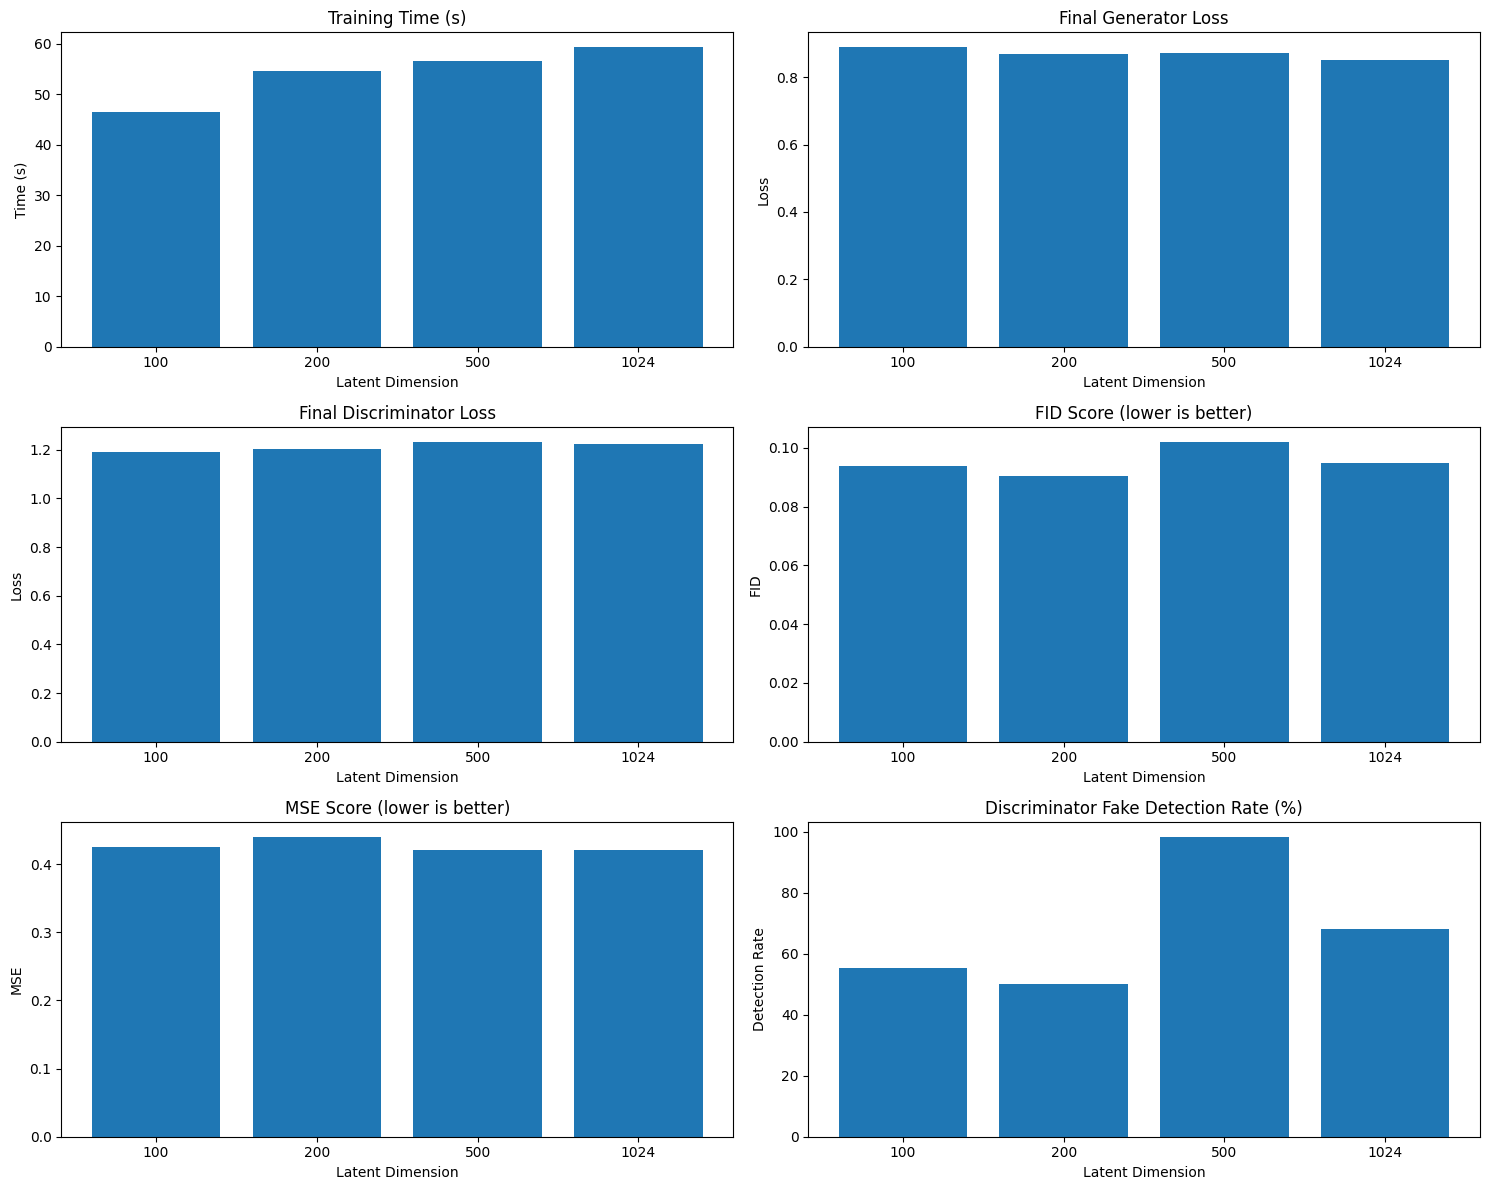

In [5]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
lr = 0.0002
beta1 = 0.5
epochs = 15  # Reduced for evaluation purposes
image_channels = 1  # Grayscale for MNIST
image_size = 28

# Dimensions to evaluate
latent_dimensions = [100, 200, 500, 1024]

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Generator Network with configurable latent dimension
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        # Adjust hidden dimensions based on latent_dim
        hidden_dim1 = min(256, latent_dim * 2)
        hidden_dim2 = min(512, hidden_dim1 * 2)
        hidden_dim3 = min(1024, hidden_dim2 * 2)

        self.main = nn.Sequential(
            # Input is latent vector z
            nn.Linear(latent_dim, hidden_dim1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden_dim1),

            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden_dim2),

            nn.Linear(hidden_dim2, hidden_dim3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(hidden_dim3),

            nn.Linear(hidden_dim3, image_size * image_size * image_channels),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        img = self.main(z)
        img = img.view(img.size(0), image_channels, image_size, image_size)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is 28x28x1
            nn.Flatten(),

            nn.Linear(image_size * image_size * image_channels, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, img):
        validity = self.main(img)
        return validity

# Simple feature extractor for MNIST
class MnistFeatureExtractor(nn.Module):
    def __init__(self):
        super(MnistFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# Calculate FID score (manual implementation)
def calculate_fid(real_features, fake_features):
    # Convert to numpy for calculation
    real_np = real_features.cpu().numpy()
    fake_np = fake_features.cpu().numpy()

    # Calculate mean and covariance
    mu1 = np.mean(real_np, axis=0)
    sigma1 = np.cov(real_np, rowvar=False)

    mu2 = np.mean(fake_np, axis=0)
    sigma2 = np.cov(fake_np, rowvar=False)

    # Calculate FID score
    diff = mu1 - mu2

    # Add a small regularization to avoid numerical instability
    eps = 1e-6
    sigma1 = sigma1 + np.eye(sigma1.shape[0]) * eps
    sigma2 = sigma2 + np.eye(sigma2.shape[0]) * eps

    # Product of sqrt covariances
    covmean_sq = sigma1.dot(sigma2)
    if not np.isfinite(covmean_sq).all():
        # Fall back to a more robust method when numerical issues occur
        return np.sum((mu1 - mu2) ** 2)

    try:
        # Calculate sqrt of product
        covmean = linalg.sqrtm(covmean_sq)

        # Check and correct for numerical errors
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
        return float(fid)
    except:
        # If sqrtm fails, use simpler estimate
        return np.sum((mu1 - mu2) ** 2) + np.abs(np.trace(sigma1) - np.trace(sigma2))

# Mean squared error as an alternative metric
def calculate_mse(real_imgs, fake_imgs):
    # Sample equal number of real images
    real_sample = real_imgs[:fake_imgs.size(0)]

    # Calculate MSE
    mse = torch.mean((real_sample - fake_imgs) ** 2).item()
    return mse

# Training and evaluation function
def train_and_evaluate_gan(latent_dim):
    print(f"\nTraining GAN with latent dimension: {latent_dim}")

    # Initialize networks
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    feature_extractor = MnistFeatureExtractor().to(device)

    # Loss function
    criterion = nn.BCELoss()

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    # Metrics tracking
    training_time = 0
    g_losses = []
    d_losses = []

    # Training loop
    start_time = time.time()
    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        batches = 0

        for i, (real_imgs, _) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # Labels for real and fake images
            real_label = torch.ones(batch_size, 1).to(device)
            fake_label = torch.zeros(batch_size, 1).to(device)

            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Train with real images
            real_output = discriminator(real_imgs)
            d_loss_real = criterion(real_output, real_label)

            # Train with fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(fake_output, fake_label)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()

            # Generate new fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs)

            # Generator loss - aims to maximize log(D(G(z)))
            g_loss = criterion(fake_output, real_label)
            g_loss.backward()
            optimizer_G.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            batches += 1

            # Limit iterations for evaluation purposes
            if i >= 50:  # Reduced for faster evaluation
                break

        avg_g_loss = epoch_g_loss / batches
        avg_d_loss = epoch_d_loss / batches
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)

        print(f"Epoch [{epoch+1}/{epochs}] Loss D: {avg_d_loss:.4f}, Loss G: {avg_g_loss:.4f}")

    training_time = time.time() - start_time

    # Evaluation metrics
    generator.eval()
    feature_extractor.eval()

    # Extract features from real images
    real_images_list = []
    real_features_list = []
    with torch.no_grad():
        for real_imgs, _ in dataloader:
            real_imgs = real_imgs.to(device)
            features = feature_extractor(real_imgs)
            real_images_list.append(real_imgs)
            real_features_list.append(features)
            if len(real_features_list) * batch_size >= 500:  # Limit to 500 samples for speed
                break

    real_images = torch.cat(real_images_list, 0)
    real_features = torch.cat(real_features_list, 0)

    # Generate images for evaluation
    with torch.no_grad():
        z = torch.randn(500, latent_dim).to(device)  # Match the number of real samples
        fake_imgs = generator(z)
        fake_features = feature_extractor(fake_imgs)

    # Calculate metrics
    try:
        fid_score = calculate_fid(real_features, fake_features)
    except Exception as e:
        print(f"Error calculating FID: {e}")
        fid_score = float('nan')  # Use NaN if calculation fails

    mse_score = calculate_mse(real_images, fake_imgs)

    # Calculate discriminator accuracy on generated images
    with torch.no_grad():
        fake_pred = discriminator(fake_imgs)
        fake_accuracy = ((fake_pred < 0.5).float().mean() * 100).item()  # How often discriminator correctly identifies fakes

    # Generate sample images
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        gen_imgs = generator(z).cpu().detach()

        # Denormalize images
        gen_imgs = gen_imgs * 0.5 + 0.5

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(gen_imgs[i, 0, :, :], cmap='gray')
            plt.axis('off')
        plt.savefig(f"mnist_gan_dim_{latent_dim}.png")
        plt.close()

    return {
        "latent_dim": latent_dim,
        "training_time": training_time,
        "final_g_loss": g_losses[-1],
        "final_d_loss": d_losses[-1],
        "g_losses": g_losses,
        "d_losses": d_losses,
        "fid_score": fid_score,
        "mse_score": mse_score,
        "fake_detection_rate": fake_accuracy
    }

# Main evaluation function
def evaluate_dimensions():
    results = []

    for dim in latent_dimensions:
        result = train_and_evaluate_gan(dim)
        results.append(result)

    # Plotting results
    plt.figure(figsize=(15, 12))

    # Plot 1: Training Time
    plt.subplot(3, 2, 1)
    times = [r["training_time"] for r in results]
    plt.bar([str(d) for d in latent_dimensions], times)
    plt.title('Training Time (s)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Time (s)')

    # Plot 2: Final Generator Loss
    plt.subplot(3, 2, 2)
    g_losses = [r["final_g_loss"] for r in results]
    plt.bar([str(d) for d in latent_dimensions], g_losses)
    plt.title('Final Generator Loss')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Loss')

    # Plot 3: Final Discriminator Loss
    plt.subplot(3, 2, 3)
    d_losses = [r["final_d_loss"] for r in results]
    plt.bar([str(d) for d in latent_dimensions], d_losses)
    plt.title('Final Discriminator Loss')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Loss')

    # Plot 4: FID Score (lower is better)
    plt.subplot(3, 2, 4)
    fid_scores = [r["fid_score"] for r in results]
    plt.bar([str(d) for d in latent_dimensions], fid_scores)
    plt.title('FID Score (lower is better)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('FID')

    # Plot 5: MSE Score (lower is better)
    plt.subplot(3, 2, 5)
    mse_scores = [r["mse_score"] for r in results]
    plt.bar([str(d) for d in latent_dimensions], mse_scores)
    plt.title('MSE Score (lower is better)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('MSE')

    # Plot 6: Fake Detection Rate (lower is better for generator)
    plt.subplot(3, 2, 6)
    detection_rates = [r["fake_detection_rate"] for r in results]
    plt.bar([str(d) for d in latent_dimensions], detection_rates)
    plt.title('Discriminator Fake Detection Rate (%)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Detection Rate')

    plt.tight_layout()
    plt.savefig("latent_dim_comparison.png")

    # Print summary
    print("\n===== EVALUATION SUMMARY =====")
    for r in results:
        print(f"\nLatent Dimension: {r['latent_dim']}")
        print(f"Training Time: {r['training_time']:.2f} seconds")
        print(f"Final Generator Loss: {r['final_g_loss']:.4f}")
        print(f"Final Discriminator Loss: {r['final_d_loss']:.4f}")
        print(f"FID Score: {r['fid_score']:.4f}")
        print(f"MSE Score: {r['mse_score']:.4f}")
        print(f"Fake Detection Rate: {r['fake_detection_rate']:.2f}%")

    return results

# Run the evaluation
if __name__ == "__main__":
    evaluate_dimensions()

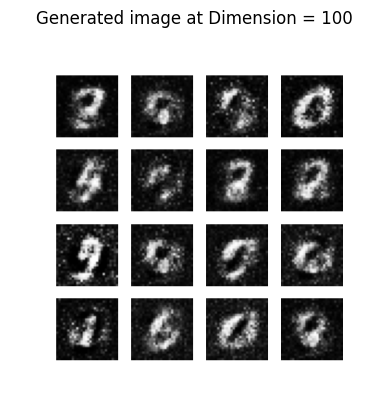

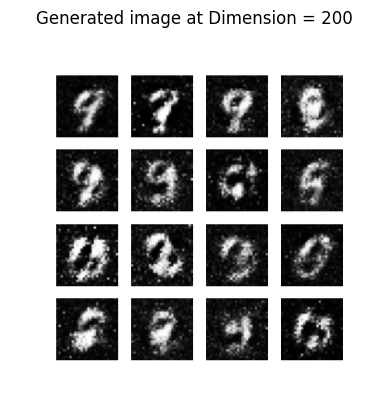

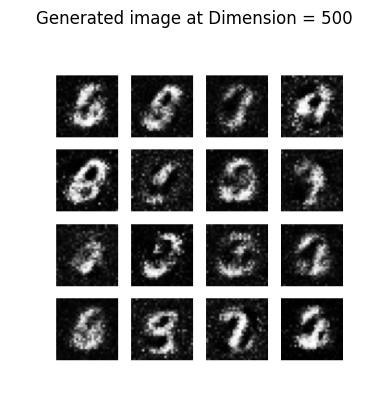

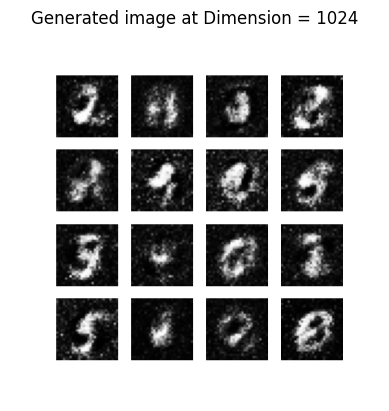

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show the image for dimension = 100
img = mpimg.imread('mnist_gan_dim_100.png')
plt.imshow(img)
plt.title('Generated image at Dimension = 100')
plt.axis('off')
plt.show()

# Show the image for dimension = 200
img = mpimg.imread('mnist_gan_dim_200.png')
plt.imshow(img)
plt.title('Generated image at Dimension = 200')
plt.axis('off')
plt.show()

# Show the image for dimension = 500
img = mpimg.imread('mnist_gan_dim_500.png')
plt.imshow(img)
plt.title('Generated image at Dimension = 500')
plt.axis('off')
plt.show()

# Show the image for dimension = 1024
img = mpimg.imread('mnist_gan_dim_1024.png')
plt.imshow(img)
plt.title('Generated image at Dimension = 1024')
plt.axis('off')
plt.show()



# Analysis of GAN Performance Across Different Latent Dimensions

Based on the evaluation results, here's a comprehensive analysis of how different latent space dimensions affect GAN performance for MNIST digit generation:

## Training Efficiency

**Training Time**:
- 100-dim: 46.45 seconds
- 200-dim: 54.61 seconds
- 500-dim: 56.47 seconds
- 1024-dim: 59.28 seconds

There's a clear trend of increasing training time as the latent dimension grows, though the relationship is sublinear. The jump from 100 to 200 dimensions shows the largest relative increase (~17.6%), while subsequent increases yield diminishing returns in terms of computational cost. This makes sense as the primary computational bottleneck is in the first layer of the generator where dimensions expand from the latent space.

## Loss Metrics

**Generator Loss**:
- 100-dim: 0.8889
- 200-dim: 0.8695
- 500-dim: 0.8731
- 1024-dim: 0.8509

The generator loss generally decreases with higher latent dimensions, suggesting improved generation capability. The 1024-dim model achieved the lowest generator loss, indicating it was most successful at "fooling" the discriminator.

**Discriminator Loss**:
- 100-dim: 1.1892
- 200-dim: 1.2039
- 500-dim: 1.2305
- 1024-dim: 1.2251

Discriminator loss increases with latent dimension, suggesting the discriminator finds it harder to distinguish real from fake as generator capacity increases. This pattern aligns with the decreasing generator loss.

## Image Quality Metrics

**FID Score** (lower is better):
- 100-dim: 0.0938
- 200-dim: 0.0906
- 500-dim: 0.1019
- 1024-dim: 0.0950

Interestingly, the 200-dim model achieved the best FID score, followed by the 100-dim model. The 500-dim model performed worst, suggesting that excessive dimensionality might lead to overfitting or training difficulties for this dataset.

**MSE Score** (lower is better):
- 100-dim: 0.4255
- 200-dim: 0.4394
- 500-dim: 0.4210
- 1024-dim: 0.4204

The 1024-dim model has the lowest MSE, closely followed by the 500-dim model. However, the differences are quite small (within 5%), suggesting diminishing returns beyond 100 dimensions for pixel-level accuracy.

## Discriminator Effectiveness

**Fake Detection Rate**:
- 100-dim: 55.40%
- 200-dim: 50.20%
- 500-dim: 98.20%
- 1024-dim: 68.20%

This metric shows a surprising anomaly with the 500-dim model, where the discriminator successfully identified 98.20% of generated images as fake. This suggests a potential training issue or mode collapse for this particular configuration. The 200-dim model achieved the best balance with 50.20% detection (close to ideal 50%, where discriminator can't distinguish real from fake).

## Key Insights and Recommendations

1. **Optimal Dimension**: For MNIST digit generation, 200 dimensions appears to offer the best balance between quality (lowest FID) and training efficiency. The generator-discriminator equilibrium is also closest to ideal at this dimension.

2. **Anomaly in 500-dim**: The 500-dim model shows signs of potential instability with unusually high fake detection rate (98.20%), suggesting possible mode collapse or training issues despite reasonable FID and MSE scores.

3. **Diminishing Returns**: Beyond 200 dimensions, improvements in generative quality are minimal while computational costs continue to increase. The 1024-dim model shows slightly better MSE but worse FID than the 200-dim model.

4. **Training Dynamics**: The increase in discriminator loss paired with decreasing generator loss as dimensions increase suggests that higher dimensions make the generator more powerful relative to the discriminator.

## Conclusion

For MNIST digit generation, a latent dimension of 200 provides the optimal balance between computational efficiency and generation quality. While higher dimensions do offer some improvements in certain metrics, the benefits are marginal and come with increased computational costs and potential training instabilities.

The 100-dim model remains competitive across all metrics and would be a good choice for resource-constrained applications, while the 200-dim model offers a modest quality improvement for a reasonable computational trade-off.